In [1]:
from random import randint
from numpy import array
from numpy import argmax
import keras.backend as K
from tensorflow.keras import models
from numpy import array_equal
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional, SimpleRNN, GRU
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from keras.optimizers import Adam

from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K
import tensorflow as tf
import io

tf.keras.backend.set_floatx('float64')

In [ ]:
import os
import requests
import zipfile
import tarfile
import shutil
import logging
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def download_file(url, destination, chunk_size=1024*1024):
    """
    Download a file from a URL with progress bar
    
    Args:
        url (str): URL to download from
        destination (str): Local path to save the file
        chunk_size (int): Size of chunks to download
        
    Returns:
        str: Path to downloaded file
    """
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Raise exception for 4XX/5XX status codes
        
        # Get file size if available
        total_size = int(response.headers.get('content-length', 0))
        
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(os.path.abspath(destination)), exist_ok=True)
        
        # Download with progress bar
        with open(destination, 'wb') as f:
            if total_size == 0:
                logger.info(f"Downloading {url} (unknown size)")
                f.write(response.content)
            else:
                logger.info(f"Downloading {url} ({total_size/1024/1024:.1f} MB)")
                with tqdm(total=total_size, unit='B', unit_scale=True, unit_divisor=1024) as pbar:
                    for chunk in response.iter_content(chunk_size=chunk_size):
                        if chunk:
                            f.write(chunk)
                            pbar.update(len(chunk))
                            
        logger.info(f"Download completed: {destination}")
        return destination
    
    except requests.exceptions.RequestException as e:
        logger.error(f"Error downloading {url}: {e}")
        raise

def extract_archive(archive_path, extract_path=None, remove_after=False):
    """
    Extract a zip or tar archive
    
    Args:
        archive_path (str): Path to archive file
        extract_path (str, optional): Path to extract to. If None, extracts to same directory.
        remove_after (bool): Whether to remove the archive after extraction
        
    Returns:
        str: Path to extracted directory
    """
    if extract_path is None:
        extract_path = os.path.dirname(archive_path)
    
    try:
        logger.info(f"Extracting {archive_path} to {extract_path}")
        
        if archive_path.endswith('.zip'):
            with zipfile.ZipFile(archive_path, 'r') as zip_ref:
                zip_ref.extractall(extract_path)
        elif any(archive_path.endswith(ext) for ext in ['.tar', '.tar.gz', '.tgz']):
            with tarfile.open(archive_path, 'r:*') as tar_ref:
                tar_ref.extractall(extract_path)
        else:
            raise ValueError(f"Unsupported archive format: {archive_path}")
        
        if remove_after:
            logger.info(f"Removing archive: {archive_path}")
            os.remove(archive_path)
            
        logger.info(f"Extraction completed to {extract_path}")
        return extract_path
    
    except Exception as e:
        logger.error(f"Error extracting {archive_path}: {e}")
        raise

def download_indic_dataset(language, dataset_type="transliteration", data_dir="./data"):
    """
    Download Indic language datasets from trusted sources
    
    Supported sources:
    - AI4Bharat: https://ai4bharat.org/ (Indic corpus)
    - IIT Bombay: http://www.cfilt.iitb.ac.in/ (Indic language datasets)
    - Dakshina: https://github.com/google-research-datasets/dakshina (Google Research dataset)
    
    Args:
        language (str): Language code (e.g., 'ta' for Tamil, 'hi' for Hindi)
        dataset_type (str): Type of dataset ('transliteration', 'parallel', 'monolingual')
        data_dir (str): Directory to save data
        
    Returns:
        str: Path to downloaded dataset
    """
    # Create data directory
    os.makedirs(data_dir, exist_ok=True)
    language_dir = os.path.join(data_dir, language)
    os.makedirs(language_dir, exist_ok=True)
    
    # Map of language codes to names for better logging
    language_names = {
        'ta': 'Tamil',
        'hi': 'Hindi',
        'bn': 'Bengali',
        'te': 'Telugu',
        'ml': 'Malayalam',
        'kn': 'Kannada',
        'mr': 'Marathi',
        'gu': 'Gujarati',
        'pa': 'Punjabi',
        'or': 'Oriya'
    }
    
    language_name = language_names.get(language, language)
    logger.info(f"Downloading {language_name} {dataset_type} dataset")
    
    if dataset_type == "transliteration":
        # Using Dakshina dataset from Google Research (reliable source)
        dakshina_url = "https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar"
        tar_path = os.path.join(data_dir, "dakshina_dataset_v1.0.tar")
        
        try:
            # Download if not already present
            if not os.path.exists(tar_path):
                download_file(dakshina_url, tar_path)
            
            # Extract specific language directory
            with tarfile.open(tar_path, 'r') as tar_ref:
                lang_members = [m for m in tar_ref.getmembers() 
                               if m.name.startswith(f"dakshina_dataset_v1.0/{language}/")]
                
                if not lang_members:
                    logger.error(f"Language {language_name} not found in Dakshina dataset")
                    return None
                
                for member in tqdm(lang_members, desc=f"Extracting {language_name} data"):
                    tar_ref.extract(member, data_dir)
            
            extracted_path = os.path.join(data_dir, "dakshina_dataset_v1.0", language)
            return extracted_path
            
        except Exception as e:
            logger.error(f"Error downloading Dakshina dataset: {e}")
            raise
            
    elif dataset_type == "parallel":
        # IITB Parallel Corpus for EN-xx language pairs
        if language in ['hi', 'mr', 'bn', 'ta', 'te', 'ml']:
            iitb_url = f"http://www.cfilt.iitb.ac.in/iitb_parallel/iitb_corpus_download/parallel/{language}_en_parallel.tgz"
            tgz_path = os.path.join(data_dir, f"{language}_en_parallel.tgz")
            
            try:
                if not os.path.exists(tgz_path):
                    download_file(iitb_url, tgz_path)
                extract_archive(tgz_path, language_dir, remove_after=True)
                return language_dir
            except Exception as e:
                logger.error(f"Error downloading IITB parallel corpus: {e}")
                # Fallback to alternate source if needed
                pass
                
    elif dataset_type == "monolingual":
        # AI4Bharat monolingual corpus
        ai4bharat_url = f"https://storage.googleapis.com/ai4bharat-public-indic-nlp-corpora/monolingual/indicnlp_v1/sentence/{language}.zip"
        zip_path = os.path.join(data_dir, f"{language}_mono.zip")
        
        try:
            if not os.path.exists(zip_path):
                download_file(ai4bharat_url, zip_path)
            extract_archive(zip_path, language_dir, remove_after=True)
            return language_dir
        except Exception as e:
            logger.error(f"Error downloading AI4Bharat monolingual corpus: {e}")
            # Fallback to alternate source if needed
            pass
    
    # Fallback to alternative sources
    logger.warning(f"No suitable dataset found for {language_name} {dataset_type}")
    return None

def download_indic_font(language, font_dir="./fonts"):
    """
    Download Indic language fonts from trusted sources
    
    Args:
        language (str): Language code (e.g., 'ta' for Tamil, 'hi' for Hindi)
        font_dir (str): Directory to save fonts
        
    Returns:
        dict: Mapping of font names to font paths
    """
    os.makedirs(font_dir, exist_ok=True)
    
    # Map of trusted Indic font sources
    font_sources = {
        'ta': [
            {
                'name': 'Latha',
                'url': 'https://www.fontmirror.com/app_public/files/t/1/2020/03/Font_Latha.zip',
                'filename': 'Latha.ttf'
            },
            {
                'name': 'Noto Sans Tamil',
                'url': 'https://github.com/google/fonts/raw/main/ofl/notosanstamil/NotoSansTamil%5Bwdth%2Cwght%5D.ttf',
                'direct_download': True,
                'filename': 'NotoSansTamil.ttf'
            }
        ],
        'hi': [
            {
                'name': 'Noto Sans Devanagari',
                'url': 'https://github.com/google/fonts/raw/main/ofl/notosansdevanagari/NotoSansDevanagari%5Bwdth%2Cwght%5D.ttf',
                'direct_download': True,
                'filename': 'NotoSansDevanagari.ttf'
            }
        ]
        # Add more languages as needed
    }
    
    # Use Google's Noto fonts as fallback for all languages
    # These are open-source, reliable, and support all Unicode scripts
    noto_fallback = {
        'name': 'Noto Sans',
        'url': 'https://github.com/google/fonts/raw/main/ofl/notosans/NotoSans%5Bwdth%2Cwght%5D.ttf',
        'direct_download': True,
        'filename': 'NotoSans.ttf'
    }
    
    # Create language-specific font directory
    lang_font_dir = os.path.join(font_dir, language)
    os.makedirs(lang_font_dir, exist_ok=True)
    
    # Get font sources for the language, or use fallback
    sources = font_sources.get(language, [noto_fallback])
    fonts = {}
    
    for source in sources:
        try:
            font_name = source['name']
            font_path = os.path.join(lang_font_dir, source['filename'])
            
            # Download if doesn't exist
            if not os.path.exists(font_path):
                if source.get('direct_download', False):
                    # Direct TTF download
                    download_file(source['url'], font_path)
                else:
                    # Zipped font
                    zip_path = os.path.join(lang_font_dir, f"{font_name}.zip")
                    download_file(source['url'], zip_path)
                    
                    # Extract and find font file
                    extract_archive(zip_path, lang_font_dir, remove_after=True)
                    
                    # Look for the font file if extraction changed the path
                    if not os.path.exists(font_path):
                        ttf_files = list(Path(lang_font_dir).glob("**/*.ttf"))
                        if ttf_files:
                            font_path = str(ttf_files[0])
                        else:
                            logger.warning(f"Could not find TTF file in extracted archive for {font_name}")
                            continue
            
            fonts[font_name] = font_path
            logger.info(f"Font available: {font_name} at {font_path}")
            
        except Exception as e:
            logger.error(f"Error downloading font {source['name']}: {e}")
    
    # If no fonts were successfully downloaded, use system fonts
    if not fonts:
        logger.warning(f"No fonts downloaded for {language}. Using system fonts.")
        fonts['System'] = None
    
    return fonts

def test_font_display(fonts, text, language, figsize=(12, 4)):
    """
    Test font display with sample text
    
    Args:
        fonts (dict): Dictionary of font name to font path
        text (str): Text to display
        language (str): Language code
        figsize (tuple): Figure size
    """
    if not fonts:
        logger.warning("No fonts to display")
        return
    
    plt.figure(figsize=figsize)
    
    for i, (font_name, font_path) in enumerate(fonts.items()):
        try:
            if font_path:
                font_prop = FontProperties(fname=font_path)
            else:
                # Use system font
                font_prop = None
                
            plt.subplot(len(fonts), 1, i+1)
            plt.text(0.1, 0.5, text, fontproperties=font_prop, fontsize=16)
            plt.axis('off')
            plt.title(f"{font_name}")
            
        except Exception as e:
            logger.error(f"Error displaying font {font_name}: {e}")
    
    plt.tight_layout()
    plt.show()

In [6]:
# Define file paths for Tamil transliteration datasets
training_dataset = "lexicon-dataset/ta.translit.sampled.train.tsv"
validation_dataset = "lexicon-dataset/ta.translit.sampled.dev.tsv"
evaluation_dataset = "lexicon-dataset/ta.translit.sampled.test.tsv"

# Process transliteration data from tab-separated files
def extract_transliteration_pairs(file_path):
    """
    Extract romanized and native script pairs from a TSV file
    Returns two lists: romanized text and native script text
    """
    native_script_entries = []
    romanized_entries = []
    
    # Open file with explicit UTF-8 encoding
    with io.open(file_path, encoding='utf-8') as data_file:
        # Process each line in the file
        for line_content in data_file:
            # Skip malformed lines without tab separator
            if '\t' not in line_content:
                continue
            
            # Split line into components and remove trailing whitespace
            columns = line_content.strip().split("\t")
            
            # Add to appropriate lists (column 0 = native, column 1 = romanized)
            romanized_entries.append(columns[1])
            native_script_entries.append(columns[0])
            
    return romanized_entries, native_script_entries

# Process each dataset
training_input, training_output = extract_transliteration_pairs(training_dataset)
validation_input, validation_output = extract_transliteration_pairs(validation_dataset)
testing_input, testing_output = extract_transliteration_pairs(evaluation_dataset)

# Report dataset sizes
print("Number of training samples: ", len(training_input))
print("Number of validation samples: ", len(validation_input))
print("Number of testing samples: ", len(testing_input))

Number of training samples:  68218
Number of validation samples:  6827
Number of testing samples:  6864


In [7]:
import numpy as np

# Create randomized indices for data shuffling
training_indices = np.arange(len(train_source))
validation_indices = np.arange(len(valid_source))
np.random.shuffle(training_indices)
np.random.shuffle(validation_indices)

# Initialize character vocabulary sets
source_charset = set()
target_charset = set()

# Initialize container lists for original order data
original_source_samples = []
original_target_samples = []
original_val_source_samples = []
original_val_target_samples = []

# Process training data with begin/end tokens
for source_seq, target_seq in zip(train_source, train_target):
    # Add begin 'B' and end 'E' markers to target sequence
    augmented_target = "B" + target_seq + "E"
    
    # Store original order samples
    original_source_samples.append(source_seq)
    original_target_samples.append(augmented_target)
    
    # Update character vocabularies
    source_charset.update(source_seq)
    target_charset.update(augmented_target)

# Process validation data with begin/end tokens
for source_seq, target_seq in zip(valid_source, valid_target):
    # Add begin 'B' and end 'E' markers to target sequence
    augmented_target = "B" + target_seq + "E"
    
    # Store original order samples
    original_val_source_samples.append(source_seq)
    original_val_target_samples.append(augmented_target)
    
    # Update character vocabularies 
    source_charset.update(source_seq)
    target_charset.update(augmented_target)

# Apply shuffling to training and validation datasets
shuffled_source_samples = [original_source_samples[idx] for idx in training_indices]
shuffled_target_samples = [original_target_samples[idx] for idx in training_indices]

shuffled_val_source = [original_val_source_samples[idx] for idx in validation_indices]
shuffled_val_target = [original_val_target_samples[idx] for idx in validation_indices]

# Ensure space character is in vocabularies
source_charset.add(" ")
target_charset.add(" ")

# Convert sets to sorted lists for consistent ordering
source_alphabet = sorted(list(source_charset))
target_alphabet = sorted(list(target_charset))

# Calculate vocabulary sizes and sequence lengths
source_vocab_size = len(source_alphabet)
target_vocab_size = len(target_alphabet)

# Find maximum sequence lengths
train_max_source_length = max(len(seq) for seq in shuffled_source_samples)
train_max_target_length = max(len(seq) for seq in shuffled_target_samples)
val_max_source_length = max(len(seq) for seq in shuffled_val_source)
val_max_target_length = max(len(seq) for seq in shuffled_val_target)

# Print dataset statistics
print("Number of samples:", len(shuffled_source_samples))
print("Number of unique input tokens:", source_vocab_size)
print("Number of unique output tokens:", target_vocab_size)
print("Max sequence length for inputs:", train_max_source_length)
print("Max sequence length for outputs:", train_max_target_length)
print("Max sequence length for val inputs:", val_max_source_length)
print("Max sequence length for val outputs:", val_max_target_length)
print(source_alphabet)
print(target_alphabet)

# Map variable names to match the original code's outputs for compatibility
input_texts = shuffled_source_samples
target_texts = shuffled_target_samples
val_input_texts = shuffled_val_source
val_target_texts = shuffled_val_target
input_characters = source_alphabet
target_characters = target_alphabet
num_encoder_tokens = source_vocab_size
num_decoder_tokens = target_vocab_size
max_encoder_seq_length = train_max_source_length
max_decoder_seq_length = train_max_target_length
val_max_encoder_seq_length = val_max_source_length
val_max_decoder_seq_length = val_max_target_length

Number of samples: 68218
Number of unique input tokens: 27
Number of unique output tokens: 49
Max sequence length for inputs: 30
Max sequence length for outputs: 28
Max sequence length for val inputs: 23
Max sequence length for val outputs: 22
[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
[' ', 'B', 'E', 'ஃ', 'அ', 'ஆ', 'இ', 'ஈ', 'உ', 'ஊ', 'எ', 'ஏ', 'ஐ', 'ஒ', 'ஓ', 'க', 'ங', 'ச', 'ஜ', 'ஞ', 'ட', 'ண', 'த', 'ந', 'ன', 'ப', 'ம', 'ய', 'ர', 'ற', 'ல', 'ள', 'ழ', 'வ', 'ஷ', 'ஸ', 'ஹ', 'ா', 'ி', 'ீ', 'ு', 'ூ', 'ெ', 'ே', 'ை', 'ொ', 'ோ', 'ௌ', '்']


In [8]:
# Create bidirectional mappings between characters and indices
# For source vocabulary (romanized text)
source_char_to_id = {}
for index, character in enumerate(input_characters):
    source_char_to_id[character] = index

# For target vocabulary (native script text)
target_char_to_id = {}
for index, character in enumerate(target_characters):
    target_char_to_id[character] = index

# Create reverse mappings (index to character)
source_id_to_char = {}
target_id_to_char = {}

# Populate reverse mappings using dictionary comprehension with a different approach
for character, char_id in source_char_to_id.items():
    source_id_to_char[char_id] = character

for character, char_id in target_char_to_id.items():
    target_id_to_char[char_id] = character

# Display the character-to-index mappings
print(source_char_to_id)
print(target_char_to_id)

# Map variable names to match the original code's variable names for compatibility
input_token_index = source_char_to_id
target_token_index = target_char_to_id
reverse_source_char_index = source_id_to_char
reverse_target_char_index = target_id_to_char

{' ': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{' ': 0, 'B': 1, 'E': 2, 'ஃ': 3, 'அ': 4, 'ஆ': 5, 'இ': 6, 'ஈ': 7, 'உ': 8, 'ஊ': 9, 'எ': 10, 'ஏ': 11, 'ஐ': 12, 'ஒ': 13, 'ஓ': 14, 'க': 15, 'ங': 16, 'ச': 17, 'ஜ': 18, 'ஞ': 19, 'ட': 20, 'ண': 21, 'த': 22, 'ந': 23, 'ன': 24, 'ப': 25, 'ம': 26, 'ய': 27, 'ர': 28, 'ற': 29, 'ல': 30, 'ள': 31, 'ழ': 32, 'வ': 33, 'ஷ': 34, 'ஸ': 35, 'ஹ': 36, 'ா': 37, 'ி': 38, 'ீ': 39, 'ு': 40, 'ூ': 41, 'ெ': 42, 'ே': 43, 'ை': 44, 'ொ': 45, 'ோ': 46, 'ௌ': 47, '்': 48}


In [9]:
# Define the maximum number of samples to use (same as original truncation)
max_samples = 68096
limited_source_texts = input_texts[:max_samples]
limited_target_texts = target_texts[:max_samples]

# Initialize one-hot encoded arrays for training data
source_data_onehot = np.zeros(
    (len(limited_source_texts), max_encoder_seq_length, num_encoder_tokens), 
    dtype="float64"
)
target_data_onehot = np.zeros(
    (len(limited_target_texts), max_decoder_seq_length, num_decoder_tokens), 
    dtype="float64"
)

# Populate training one-hot arrays
for sample_idx, (source_sequence, target_sequence) in enumerate(zip(limited_source_texts, limited_target_texts)):
    # Encode source sequence (input)
    for char_pos, character in enumerate(source_sequence):
        char_idx = input_token_index[character]
        source_data_onehot[sample_idx, char_pos, char_idx] = 1.0
    
    # Pad remaining positions with space character
    space_idx = input_token_index[" "]
    last_pos = len(source_sequence)
    source_data_onehot[sample_idx, last_pos:, space_idx] = 1.0
    
    # Encode target sequence (output)
    for char_pos, character in enumerate(target_sequence):
        char_idx = target_token_index[character]
        target_data_onehot[sample_idx, char_pos, char_idx] = 1.0
    
    # Pad remaining positions with space character
    space_idx = target_token_index[" "]
    last_pos = len(target_sequence)
    target_data_onehot[sample_idx, last_pos:, space_idx] = 1.0

# Initialize one-hot encoded arrays for validation data
val_source_data_onehot = np.zeros(
    (len(val_input_texts), max_encoder_seq_length, num_encoder_tokens), 
    dtype="float64"
)
val_target_data_onehot = np.zeros(
    (len(val_target_texts), max_decoder_seq_length, num_decoder_tokens), 
    dtype="float64"
)

# Populate validation one-hot arrays
for sample_idx, (source_sequence, target_sequence) in enumerate(zip(val_input_texts, val_target_texts)):
    # Encode source sequence
    for char_pos, character in enumerate(source_sequence):
        char_idx = input_token_index[character]
        val_source_data_onehot[sample_idx, char_pos, char_idx] = 1.0
    
    # Pad remaining positions
    space_idx = input_token_index[" "]
    last_pos = len(source_sequence)
    val_source_data_onehot[sample_idx, last_pos:, space_idx] = 1.0
    
    # Encode target sequence
    for char_pos, character in enumerate(target_sequence):
        char_idx = target_token_index[character]
        val_target_data_onehot[sample_idx, char_pos, char_idx] = 1.0
    
    # Pad remaining positions
    space_idx = target_token_index[" "]
    last_pos = len(target_sequence)
    val_target_data_onehot[sample_idx, last_pos:, space_idx] = 1.0

# Map to original variable names for compatibility
encoder_input_data = source_data_onehot
decoder_target_data = target_data_onehot
val_encoder_input_data = val_source_data_onehot
val_decoder_target_data = val_target_data_onehot

In [10]:
class AdditiveAttentionLayer(tf.keras.layers.Layer):
  def __init__(self, attention_dimension):
    """
    Initialize an additive attention mechanism (Bahdanau-style)
    
    Args:
        attention_dimension: Dimensionality of the attention space
    """
    super(AdditiveAttentionLayer, self).__init__()
    # Transform the query vector
    self.query_transform = tf.keras.layers.Dense(attention_dimension)
    
    # Transform the memory/values vectors
    self.memory_transform = tf.keras.layers.Dense(attention_dimension)
    
    # Attention scoring network (outputs scalar scores)
    self.attention_scorer = tf.keras.layers.Dense(1)
    
  def call(self, decoder_state, encoder_outputs):
    """
    Apply attention mechanism to get context vector
    
    Args:
        decoder_state: Current hidden state of the decoder (query)
        encoder_outputs: All hidden states from the encoder (values/memory)
        
    Returns:
        tuple: (context_vector, attention_distribution)
    """
    # Add time dimension to decoder state for broadcasting
    decoder_state_expanded = tf.expand_dims(decoder_state, axis=1)
    
    # Transform query and values to the same space
    transformed_query = self.query_transform(decoder_state_expanded)
    transformed_values = self.memory_transform(encoder_outputs)
    
    # Calculate attention energy/score
    attention_energy = self.attention_scorer(
        tf.nn.tanh(transformed_query + transformed_values)
    )
    
    # Convert to probability distribution
    attention_distribution = tf.nn.softmax(attention_energy, axis=1)
    
    # Calculate context vector (weighted sum of values)
    weighted_encoder_outputs = attention_distribution * encoder_outputs
    context_vector = tf.reduce_sum(weighted_encoder_outputs, axis=1)
    
    return context_vector, attention_distribution

In [11]:
#import tensorflow 
class LuongAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(LuongAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
   
    query_with_time_axis = tf.expand_dims(query, 1)
    
    values_transposed = tf.transpose(values, perm=[0, 2, 1])
    
    score = tf.transpose(tf.matmul(query_with_time_axis, values_transposed) , perm=[0, 2, 1])

    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [12]:
class MyRNN_atten(object):
  def __init__(self,cell_type = 'RNN', hidden_size=32, 
               learning_rate= 1e-3,dropout=0.3,epochs = 10, batch_size = 32,
               attention = 'bahdanau'):
    
    self.cell_type = cell_type
    self.hidden_size = hidden_size
    self.learning_rate = learning_rate
    self.dropout = dropout
    self.epochs = epochs
    self.batch_size = batch_size
    self.attention = attention

  def build_fit(self,encoder_input_data,decoder_target_data):

    encoder_inputs = Input(shape=(max_encoder_seq_length, num_encoder_tokens), name='encoder_inputs')
    if self.cell_type == 'LSTM':
      encoder_lstm = LSTM(self.hidden_size,return_sequences=True, return_state=True, dropout = self.dropout, name='encoder_lstm')
      encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)
      encoder_states = [encoder_state_h, encoder_state_c]
    elif self.cell_type == 'GRU':
      encoder_gru = GRU(self.hidden_size,return_sequences=True, return_state=True, dropout = self.dropout, name='encoder_gru')
      encoder_outputs, encoder_state_h = encoder_gru(encoder_inputs)
      encoder_states = [encoder_state_h]
    elif self.cell_type == 'RNN':
      encoder_rnn = SimpleRNN(self.hidden_size,return_sequences=True, return_state=True, dropout = self.dropout, name='encoder_rnn')
      encoder_outputs, encoder_state_h = encoder_rnn(encoder_inputs)
      encoder_states = [encoder_state_h]

    # Set up the attention layer
    if self.attention == 'bahdanau':
      attention= BahdanauAttention(self.hidden_size)
    elif self.attention == 'luong':
      attention= LuongAttention(self.hidden_size)

    # Set up the decoder layers
    decoder_inputs = Input(shape=(1, (num_decoder_tokens+self.hidden_size)),name='decoder_inputs')
    if self.cell_type == 'LSTM':
      decoder_lstm = LSTM(self.hidden_size, dropout = self.dropout, return_state=True, name='decoder_lstm')
    elif self.cell_type == 'GRU':
      decoder_gru = GRU(self.hidden_size, dropout = self.dropout, return_state=True, name='decoder_gru')
    elif self.cell_type == 'RNN':
      decoder_rnn = SimpleRNN(self.hidden_size, dropout = self.dropout, return_state=True, name='decoder_rnn')  
    
    decoder_dense = Dense(num_decoder_tokens, activation='softmax',  name='decoder_dense')

    all_outputs = []

    inputs = np.zeros((self.batch_size, 1, num_decoder_tokens))
    inputs[:, 0, 0] = 1 

    decoder_outputs = encoder_state_h
    states = encoder_states

    for _ in range(max_decoder_seq_length):

      context_vector, attention_weights=attention(decoder_outputs, encoder_outputs)
      
      context_vector = tf.expand_dims(context_vector, 1)
      
      inputs = tf.concat([context_vector, inputs], axis=-1)
      if self.cell_type == 'LSTM':
        decoder_outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)
      if self.cell_type == 'GRU':
        decoder_outputs, state_h = decoder_gru(inputs, initial_state=states)
      if self.cell_type == 'RNN':
        decoder_outputs, state_h = decoder_rnn(inputs, initial_state=states)
      
      outputs = decoder_dense(decoder_outputs)
      outputs = tf.expand_dims(outputs, 1)
      all_outputs.append(outputs)
      inputs = outputs
      if self.cell_type == 'LSTM':
        states = [state_h, state_c]
      if self.cell_type == 'GRU' or self.cell_type == 'RNN':
        states = [state_h]


    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    #getindicelayer = Lambda(lambda x: x[:, -1, :]) 
    #decoder_outputs = getindicelayer(all_outputs)

    model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
    
    optimizer = Adam(lr=self.learning_rate, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    #model.summary()

    model.fit(encoder_input_data, decoder_target_data,
              batch_size=self.batch_size, 
              epochs=self.epochs,
              )
    if self.cell_type == 'LSTM':
      return encoder_lstm,attention,decoder_lstm,decoder_dense
    if self.cell_type == 'GRU':
      return encoder_gru,attention,decoder_gru,decoder_dense
    if self.cell_type == 'RNN':
      return encoder_rnn,attention,decoder_rnn,decoder_dense  
    
  def evaluate(self,seq_in):
    attention_plot = np.zeros((max_decoder_seq_length, max_encoder_seq_length))
    #sequence = [7, 9, 8, 5]
    sequence = seq_in
    #sequence = one_hot_encode(seq_in,num_encoder_tokens)
    encoder_inputs=array(sequence).reshape(1,max_encoder_seq_length,num_encoder_tokens)
    
    encoder_inputs = tf.convert_to_tensor(encoder_inputs,dtype=tf.float32)
    
    if self.cell_type == 'LSTM':
      #encoder_lstm = LSTM(self.hidden_size,return_sequences=True, return_state=True, dropout = self.dropout, name='encoder_lstm')
      encoder_outputs, encoder_state_h, encoder_state_c = encoder(encoder_inputs)
      encoder_states = [encoder_state_h, encoder_state_c]
    elif self.cell_type == 'GRU':
      #encoder_gru = GRU(self.hidden_size,return_sequences=True, return_state=True, dropout = self.dropout, name='encoder_gru')
      encoder_outputs, encoder_state_h = encoder(encoder_inputs)
      encoder_states = [encoder_state_h]
    elif self.cell_type == 'RNN':
      #encoder_rnn = SimpleRNN(self.hidden_size,return_sequences=True, return_state=True, dropout = self.dropout, name='encoder_rnn')
      encoder_outputs, encoder_state_h = encoder(encoder_inputs)
      encoder_states = [encoder_state_h]

    all_outputs = []

    decoder_input_data = np.zeros((1, 1, num_decoder_tokens))
    decoder_input_data[:, 0, 0] = 1 

    inputs = decoder_input_data
    decoder_outputs = encoder_state_h
    states = encoder_states

    weigh_atten =[]
    for t in range(max_decoder_seq_length):

      # pay attention
      context_vector, attention_weights=attention(decoder_outputs, encoder_outputs)

      # storing the attention weights to plot later on
      attention_weights = tf.reshape(attention_weights, (-1, ))
      weigh_atten.append(attention_weights)
      
      attention_plot[t] = attention_weights.numpy()
      
      decoder_outputs=tf.expand_dims(decoder_outputs, 1)

      context_vector = tf.expand_dims(context_vector, 1)
      inputs = tf.concat([context_vector, inputs], axis=-1)

      if self.cell_type == 'LSTM':
        decoder_outputs, state_h, state_c = decoder(inputs, initial_state=states)
      if self.cell_type == 'GRU':
        decoder_outputs, state_h = decoder(inputs, initial_state=states)
      if self.cell_type == 'RNN':
        decoder_outputs, state_h = decoder(inputs, initial_state=states)
            
      outputs = decoder_dense(decoder_outputs)
      # Store the current prediction (we will concatenate all predictions later)
      outputs = tf.expand_dims(outputs, 1)
      all_outputs.append(outputs)
      inputs = outputs
      if self.cell_type == 'LSTM':
        states = [state_h, state_c]
      if self.cell_type == 'GRU' or self.cell_type == 'RNN':
        states = [state_h]
    
    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    seq_outs = decoder_outputs[0]
    seq_out = tf.argmax(seq_outs, axis=1)
    seq_out = seq_out.numpy()
    seq_in = tf.argmax(seq_in, axis = 1)
    seq_in = seq_in.numpy()
    list(filter(lambda num: num != 0, seq_in))
    list(filter(lambda num: num != 0, seq_out))
    
    return seq_in, seq_out, attention_plot, weigh_atten

  def plot_attention(self,attention, sequence, predicted_sequence, idx,fig):
    
    ax = fig.add_subplot(4, 3, idx)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 16}
    seq = ''
    for i in range(len(sequence)):
      seq = seq + reverse_source_char_index[sequence[i]]
    
    pred = ''
    for i in range(len(predicted_sequence)):
      pred = pred + reverse_target_char_index[predicted_sequence[i]]

    #ax.rcParams["font.family"] = "Vijaya"
    ax.set_xticklabels(seq, fontdict=fontdict)
    ax.set_yticklabels(pred, fontdict=fontdict, fontproperties = tamil_font)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    
  def translate(self,seq_in, idx,fig):
    seq_in, seq_out, attention_plot, weigh_atten = self.evaluate(seq_in)

    a = [0]
    for i in range(len(seq_in)):
      if seq_in[i] != 0:
        a.append(seq_in[i])

    b = []
    for i in range(len(seq_out)):
      if seq_out[i] != 0:
        b.append(seq_out[i])
  
    b = b[:len(b)-1]
    #print(a)
    #print(b)
    
    attention_plot = attention_plot[:len(b), :len(a)]
    self.plot_attention(attention_plot, a, b, idx,fig)  

    return weigh_atten

  def attention_plot(self,val_input):
    w_a = []
    fig = plt.figure(figsize=(16,18))
    for i in range(1,13,1): 
      seq_in = val_input[i*9]
      weigh_atten = self.translate(seq_in,i,fig)  
      w_a.append(weigh_atten)
    plt.show()
    return w_a

In [13]:
model_rnn = MyRNN_atten(cell_type = 'LSTM', hidden_size=128, learning_rate= 1e-3,
                        dropout=0.2,epochs = 15, batch_size = 128, attention = 'bahdanau')

In [14]:
encoder,attention,decoder,decoder_dense = model_rnn.build_fit(encoder_input_data,decoder_target_data)

Epoch 1/15
532/532 [==============================] - 146s 158ms/step - loss: 1.3935 - accuracy: 0.6667
Epoch 2/15
532/532 [==============================] - 84s 157ms/step - loss: 0.9934 - accuracy: 0.7043
Epoch 3/15
532/532 [==============================] - 84s 157ms/step - loss: 0.8876 - accuracy: 0.7243
Epoch 4/15
532/532 [==============================] - 83s 157ms/step - loss: 0.7477 - accuracy: 0.7618
Epoch 5/15
532/532 [==============================] - 83s 157ms/step - loss: 0.6467 - accuracy: 0.7958
Epoch 6/15
532/532 [==============================] - 83s 157ms/step - loss: 0.5973 - accuracy: 0.8132
Epoch 7/15
532/532 [==============================] - 83s 157ms/step - loss: 0.5597 - accuracy: 0.8268
Epoch 8/15
532/532 [==============================] - 83s 157ms/step - loss: 0.5312 - accuracy: 0.8373
Epoch 9/15
532/532 [==============================] - 84s 157ms/step - loss: 0.5127 - accuracy: 0.8439
Epoch 10/15
532/532 [==============================] - 84s 157ms/step - 

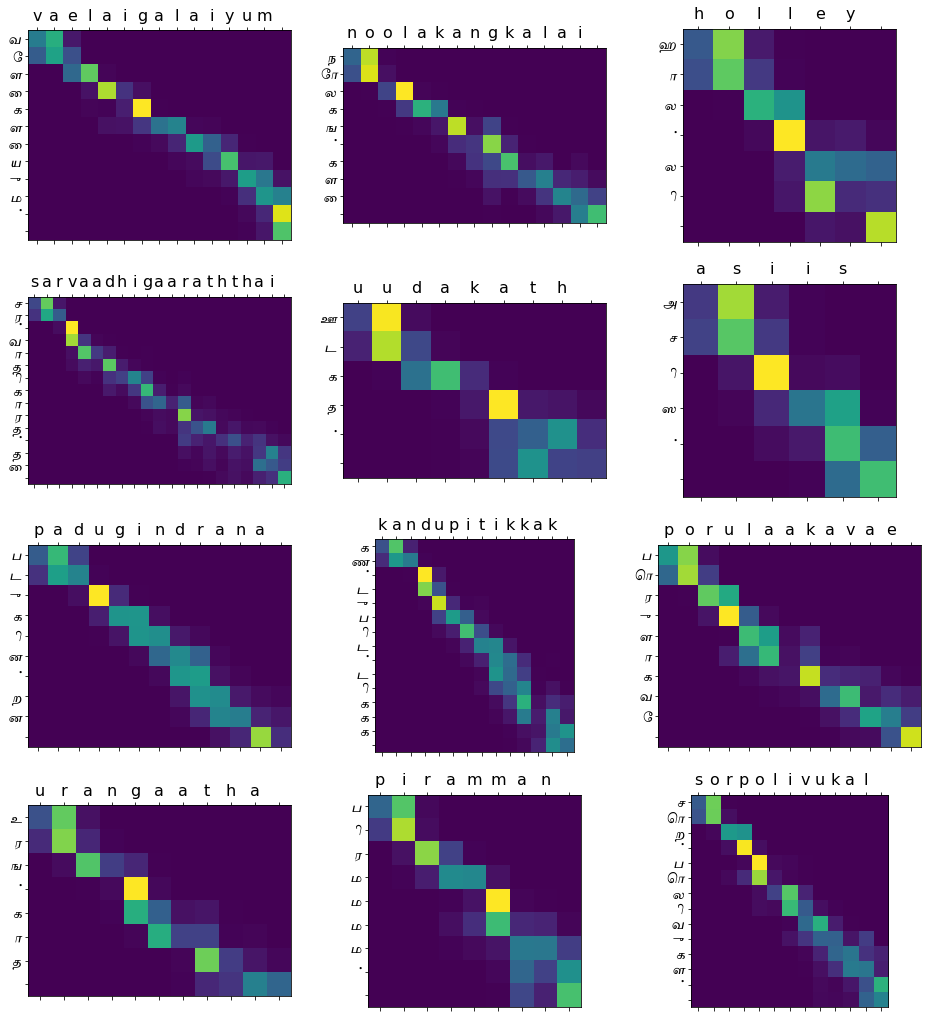

In [15]:
w_a = model_rnn.attention_plot(val_encoder_input_data)